<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/TrDesign_GD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
%%bash
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/models.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/utils.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/1QYS.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/bkgr_models.zip
unzip -qqo models.zip
unzip -qqo bkgr_models.zip

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt
from utils import *
from models import *

#**PART 1** - Design a new sequence for a given protein backbone!

## Load features from PDB

In [4]:
pdb = prep_input("1QYS.pdb", chain="A")
_feat = pdb["feat"]
_seq = np.eye(20)[AA_to_N(pdb["seq"])]

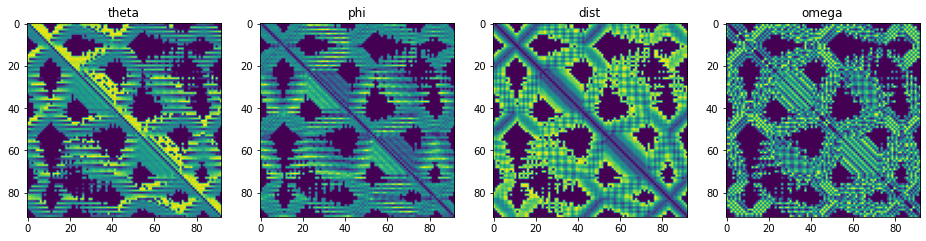

In [124]:
def plot_feat(x):
  plt.figure(figsize=(4*4,4))
  for n,(k,v) in enumerate(split_feat(x).items()):
    plt.subplot(1,4,n+1); plt.title(k)
    plt.imshow(np.squeeze(v).argmax(-1))
  plt.show()

plot_feat(_feat)

## setup design run

In [6]:
# in practice you should ALWAYS use n_models=5, for demo, we'll use n_models=1
model = mk_design_model(add_pdb=True, n_models=1)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


make a prediction using native sequence

In [7]:
pred = model.predict(inputs={"I":_seq[None,None],"pdb":_feat[None]},weights={})

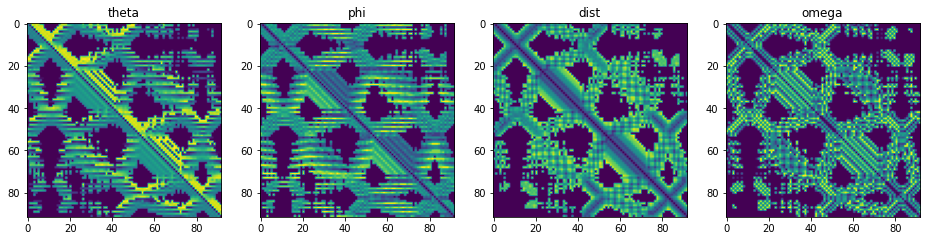

In [8]:
plot_feat(pred["feat"])

## Let's design a new sequence!

In [9]:
# note return_traj will return the predicted structure at EVERY iteration
# you'll quickly run out of memory, should only be used for demo/analysis.
design = model.design(inputs={"pdb":_feat[None]}, weights={}, return_traj=True)

10 loss:{'pdb':2.2925565}
20 loss:{'pdb':1.588461}
30 loss:{'pdb':1.3827933}
40 loss:{'pdb':1.3523289}
50 loss:{'pdb':1.287821}
60 loss:{'pdb':1.3107764}
70 loss:{'pdb':1.3998684}
80 loss:{'pdb':1.2655534}
90 loss:{'pdb':1.2475549}
100 loss:{'pdb':1.267287}
FINAL loss:{'pdb':1.2475549}


In [119]:
# the reported loss it the categorical cross entropy
-(_feat * np.log(design["feat"])).sum(-1).mean()/4

1.2475548839602382

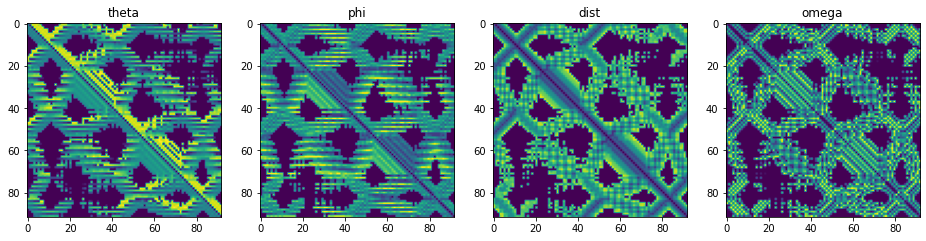

In [10]:
plot_feat(design["feat"])

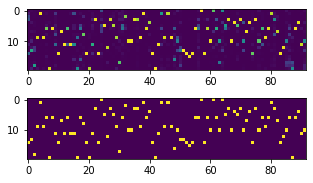

['PFYIRIEVEKPGKEKKVEHPVKDPAQMDQIWENLLDDIRECPVKRIRITLFFPSPEEAPELAELAQDLCQDLGCPDLEIERDGPMLEVECKL']

In [98]:
plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.imshow(design["I_pssm"][0].T)
plt.subplot(2,1,2)
plt.imshow(np.eye(20)[design["I"][0].argmax(-1)].T)
plt.show()

N_to_AA(design["I"].argmax(-1))

## Let's make a movie!

In [113]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML

def animate(x):
  fig, imgs = plt.figure(figsize=(6,4), dpi=100),[]
  gs = GridSpec(1,4, figure=fig)
  ax1 = fig.add_subplot(gs[0,:3]); ax1.axis(False)
  ax2 = fig.add_subplot(gs[0,3]); ax2.axis(False)
  for k,out in enumerate(x["traj"]):
    pred = split_feat(out["feat"])["dist"][0].argmax(-1)
    pssm = out["pssm"][0,0]
    im1 = ax1.imshow(pred, animated=True)
    im2 = ax2.imshow(pssm, animated=True,vmin=0,vmax=1)
    imgs.append([im1,im2])
  ani = animation.ArtistAnimation(fig, imgs, blit=True, interval=40)
  plt.close()
  return ani.to_html5_video()

In [114]:
HTML(animate(design))

#**PART 2** - Time to hallucinate a new Protein!

In [120]:
# first we need a background distribution
length = 100
bkg = get_bkg([length])[length]

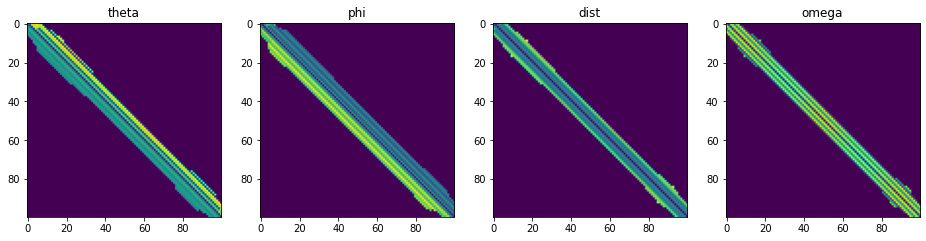

In [125]:
plot_feat(bkg)

In [126]:
# in practice you should ALWAYS use n_models=5, for demo, we'll use n_models=1
# for hallucination design we find that sampling instead of taking argmax allows for sampling 
# lower global optima
model = mk_design_model(add_bkg=True, n_models=1, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['bkg']


In [128]:
# note return_traj will return the predicted structure at EVERY iteration
# you'll quickly run out of memory, should only be used for demo/analysis.
design = model.design(inputs={"bkg":bkg[None]}, weights={}, return_traj=True, opt_iter=200)

10 loss:{'bkg':-0.25049525}
20 loss:{'bkg':-0.46014747}
30 loss:{'bkg':-0.5794285}
40 loss:{'bkg':-0.7563429}
50 loss:{'bkg':-0.868392}
60 loss:{'bkg':-0.8852114}
70 loss:{'bkg':-0.9142584}
80 loss:{'bkg':-0.9609793}
90 loss:{'bkg':-0.942642}
100 loss:{'bkg':-0.9889381}
110 loss:{'bkg':-1.0024924}
120 loss:{'bkg':-1.0212876}
130 loss:{'bkg':-1.0167788}
140 loss:{'bkg':-1.0414946}
150 loss:{'bkg':-1.0468278}
160 loss:{'bkg':-1.0540444}
170 loss:{'bkg':-1.0619035}
180 loss:{'bkg':-1.0578684}
190 loss:{'bkg':-1.0409613}
200 loss:{'bkg':-1.0656158}
FINAL loss:{'bkg':-1.0593406}


In [134]:
# the reported loss it the Kullback–Leibler divergence
-(design["feat"] * np.log(design["feat"]/bkg)).sum(-1).mean()/4

-1.0593408346176147

In [131]:
# sequence of the design
N_to_AA(design["I"].argmax(-1))

['QKVTIDEVAEKAMEEAGVKRDEKIEFEHPNQEVEIKIRMVGPGQCRIHVRDPDDPNKMPKQNQNARNWAKKACHELYKENPELNDLYQEENGKPMDPDDI']

In [129]:
HTML(animate(design))

## But.. but, how do I see my protein... in 3D?
Normally we'd input the predicted constraints into PyRosetta... but since this is quite expensive to run, for demo purposes let's use an approximation!

In [136]:
%%bash
pip -q install py3Dmol
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/to_pdb.py

In [137]:
import py3Dmol
from to_pdb import *

In [142]:
seq = N_to_AA(design["I"].argmax(-1))[0]
xyz, dm = feat_to_xyz(design["feat"])
save_PDB("out.pdb", xyz, dm, seq)

In [143]:
p = py3Dmol.view()
p.addModel(open("out.pdb",'r').read(),'pdb')
p.setStyle({'cartoon': {'color':'spectrum'}})
p.zoomTo()
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol